In [1]:
import pylab as pl
import pandas as pd
import seaborn as sns

from qufit import *

---
Read the data and model specs from a config file:

In [2]:
cfg_file = 'configs/xmmlss12.cfg'

Initialise the fitting class and run the fit. This config file specifies 3 fits (ML, MCMC, Nested) using a simple faraday thin (SFT) model:

In [3]:
qufit = QUfit(cfg_file)

In [4]:
qufit.run_qu()

100%|███████████████████████████████████████| 3695/3695 [22:03<00:00,  2.79it/s]


In [5]:
df = pd.read_csv(qufit.cfg.outfile)
df.head()

,SRCID,$P_0$_ML,$\phi_0$_ML,$\chi_0$_ML,$P_0$_MCMC,$P_0$_lo,$P_0$_hi,$\phi_0$_MCMC,$\phi_0$_lo,$\phi_0$_hi,$\chi_0$_MCMC,$\chi_0$_lo,$\chi_0$_hi
0,2873,12.440298,-26.295053,-0.088062,19.939598,2.489096,2.425412,21.637119,2.897695,1.983749,-1.339527,0.159124,0.242831
1,6187,1.893644,298.405678,-0.316020,10.632956,0.126749,0.125227,10.714546,1.218994,0.563369,1.410044,2.978299,0.046631
2,3570,11.413995,12.043041,0.385319,11.364508,0.869494,0.859740,12.016723,2.010680,1.997540,0.388095,0.171437,0.171690
3,2055,17.348279,14.160993,0.692451,17.147343,1.906296,1.889110,14.186430,2.582501,2.584656,0.688699,0.214227,0.210557
4,6972,51.019458,37.603314,1.570796,67.058242,6.332864,6.361060,13.795398,3.298015,3.230545,0.647334,0.298477,0.301061


Plot model fits onto data:

In [6]:
data = qufit.data
q_ml, u_ml = qufit.model.model(qufit.parms_ml, data.l2)
q_exp, u_exp = qufit.model.model(qufit.parms_mcmc[:,0], data.l2)

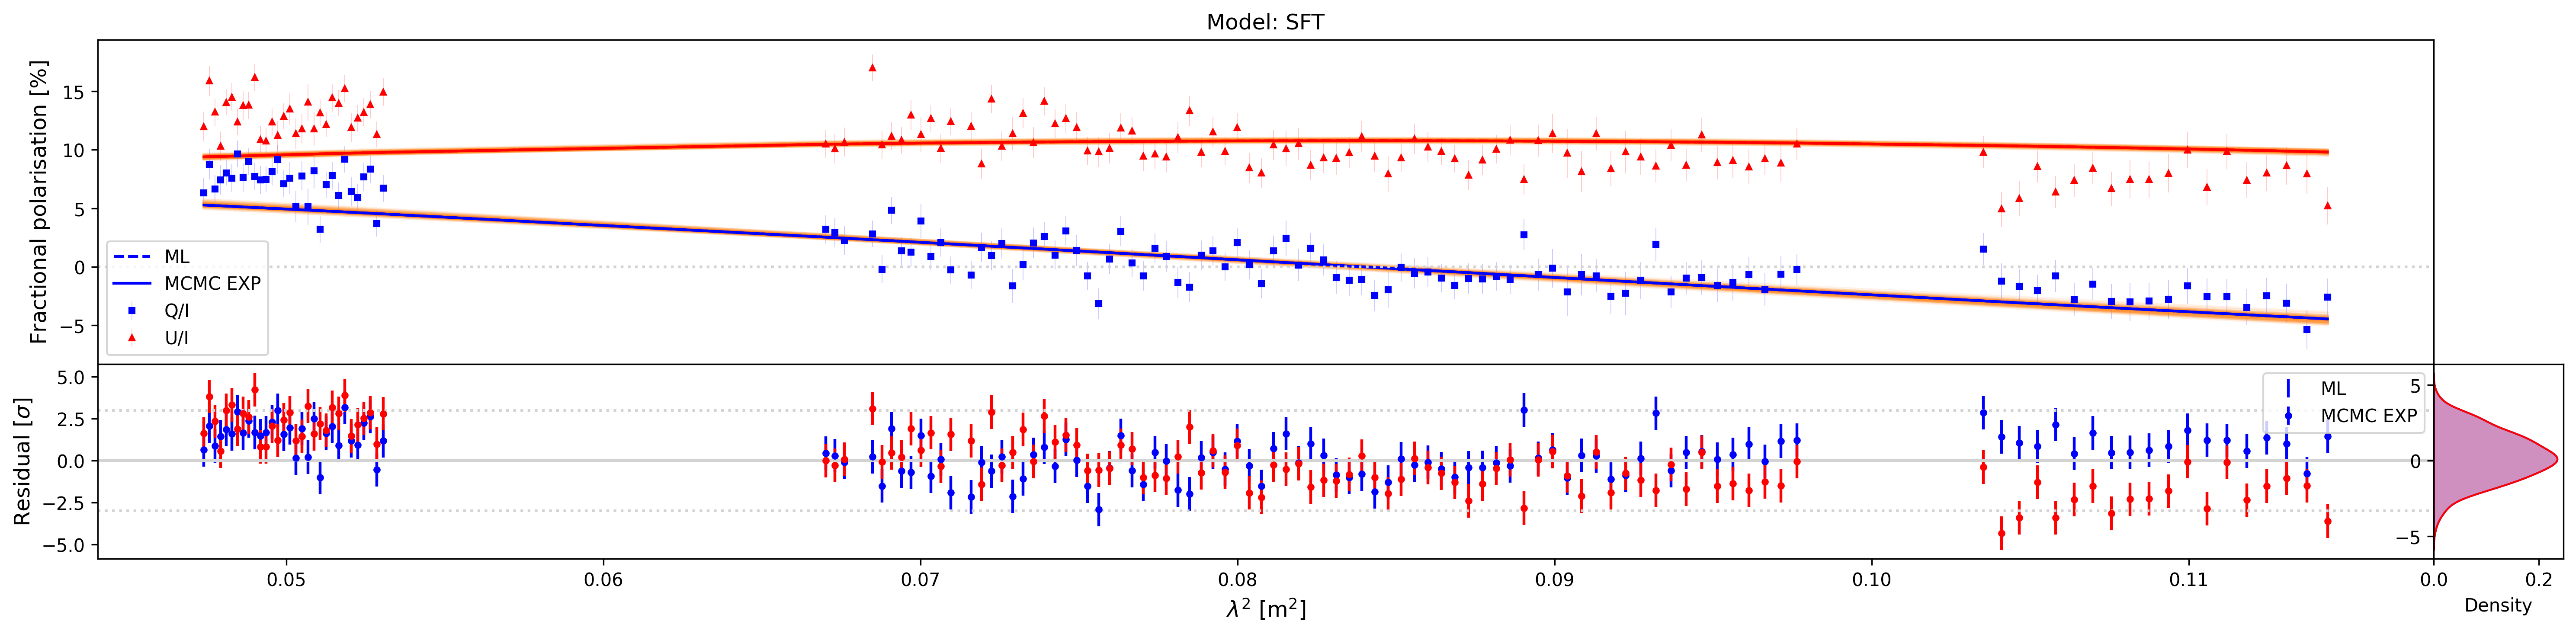

In [7]:
fig = pl.figure()

# ----------
# Q,U

ax1 = fig.add_axes([0.1, 0.4, 0.9, 0.5])

if not qufit.cfg.pol_frac:
    ax1.errorbar(data.l2[::-1],data.stokesQn[::-1], yerr=data.noise, fmt='s', ms=3, c='blue', capthick=0, lw=0.1, label='Q')
    ax1.errorbar(data.l2[::-1],data.stokesUn[::-1], yerr=data.noise, fmt='^', ms=3, c='red', capthick=0, lw=0.1, label='U')
else:
    ax1.errorbar(data.l2[::-1],data.stokesQn[::-1], yerr=data.noise, fmt='s', ms=3, c='blue', capthick=0, lw=0.1, label='Q/I')
    ax1.errorbar(data.l2[::-1],data.stokesUn[::-1], yerr=data.noise, fmt='^', ms=3, c='red', capthick=0, lw=0.1, label='U/I')

    
# 50 random samples from the posterior...   
color = "#ff7f0e"
samples = qufit.model.mcmc_samples
for s in samples[np.random.randint(len(samples), size=50)]:
    mu_q, mu_u = qufit.model.model(s, data.l2)
    ax1.plot(data.l2[::-1],mu_q[::-1], c=color, alpha=0.1)
    ax1.plot(data.l2[::-1],mu_u[::-1], c=color, alpha=0.1)

ax1.plot(data.l2[::-1],q_ml[::-1], c='blue', ls='dashed', label='ML')
ax1.plot(data.l2[::-1],u_ml[::-1], c='red', ls='dashed')
ax1.plot(data.l2[::-1],q_exp[::-1], c='blue', label='MCMC EXP')
ax1.plot(data.l2[::-1],u_exp[::-1], c='red')

ax1.axhline(y=0, ls=':', c='lightgray')
if not qufit.cfg.pol_frac:
    ax1.set_ylabel(r"Intensity [$\mu$Jy/beam]", fontsize=12)
else:
    ax1.set_ylabel(r"Fractional polarisation [$\%$]", fontsize=12)
    
#ax1.set_xlabel(r"$\lambda^2$ [m$^2$]", fontsize=12)
ax1.legend()
ax1.set_title("Model: {}".format(qufit.cfg.modeltype))


# ----------
# Q,U residuals

ax2 = fig.add_axes([0.1, 0.1, 0.9, 0.3])

q_ml_res = (data.stokesQn - q_ml)/data.noise
u_ml_res = (data.stokesUn - u_ml)/data.noise

q_exp_res = (data.stokesQn - q_exp)/data.noise
u_exp_res = (data.stokesUn - u_exp)/data.noise

ax2.errorbar(data.l2[::-1], q_ml_res[::-1], yerr = np.ones_like(q_ml_res), c='blue', ls='', ms=3, label='ML')
ax2.errorbar(data.l2[::-1], u_ml_res[::-1], yerr = np.ones_like(u_ml_res), c='red', ls='', ms=3)
ax2.errorbar(data.l2[::-1], q_exp_res[::-1], yerr = np.ones_like(q_exp_res), c='blue', fmt='o', ls='', ms=3, label='MCMC EXP')
ax2.errorbar(data.l2[::-1], u_exp_res[::-1], yerr = np.ones_like(q_exp_res), c='red', fmt='o', ls='', ms=3)

ax2.axhline(y=0, ls='-', c='lightgray')
ax2.axhline(y=3, ls=':', c='lightgray')
ax2.axhline(y=-3, ls=':', c='lightgray')

if not qufit.cfg.pol_frac:
    ax2.set_ylabel(r"Intensity [$\mu$Jy/beam]", fontsize=12)
else:
    ax2.set_ylabel(r"Residual [$\sigma$]", fontsize=12)
    
ax2.set_xlabel(r"$\lambda^2$ [m$^2$]", fontsize=12)
ax2.legend()

# ----------
# Q,U residual histogram

ax3 = fig.add_axes([1.0, 0.1, 0.05, 0.3])
#ax3.hist(np.concatenate([q_ml_res,u_ml_res]), bins=10, orientation="horizontal", alpha=0.3)

sns.kdeplot(y=np.concatenate([q_ml_res,u_ml_res]), label = 'ML', fill=True, color='blue', ax=ax3)
sns.kdeplot(y=np.concatenate([q_exp_res,u_exp_res]), label = 'MCMC', fill=True, color='red', ax=ax3)

pl.show()